<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 Web APIs and NLP

_Authors: Joel Quek (SG)_

# Problem Statement

NLP Model to match posts from r/investing, r/stockmarket, r/wallstreetbets

[Reddit Post Classification](https://towardsdatascience.com/reddit-post-classification-b70258d6affe)

[Text Cleaning for NLP: A Tutorial](https://monkeylearn.com/blog/text-cleaning/) [Important]

# Exploratory Data Analysis

## Import Libraries

In [264]:
#All libraries used in this project are listed here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import re
from bs4 import BeautifulSoup 

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, make_scorer, recall_score, precision_score,accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


# Open Scraped Datasets

The jupytyer notebooks for scraping are 'reddit-scrape.ipynb' and 'wallstreetbets-scrape.ipynb'

In [186]:
investing_df = pd.read_csv('datasets/investing.csv')
stockmarket_df = pd.read_csv('datasets/stockmarket.csv')

## r/investing

In [187]:
investing_df.shape

(7995, 75)

In [188]:
investing_df.iloc[investing_df.shape[0]-1]['created_utc']

# GMT: Friday, July 8, 2022 9:18:46 AM

1657271926

In [189]:
investing_df=investing_df[['subreddit', 'author', 'selftext', 'title']]
investing_df.head()

,subreddit,author,selftext,title
0,investing,HomeInvading,"Hey guys, I’m a 22 year old male, I grew up wi...",Help a young man out would ya?
1,investing,ocean-airseashell10,[removed],Treasury bonds is it a good idea to buy
2,investing,ocean-airseashell10,[removed],How to buy treasury bonds? Is treasury’s direc...
3,investing,iamjokingiamserious,[removed],Early Exercise of Stock Options
4,investing,jamesterryburke01,Hello Redditors 👋 \n\nI work as a Investment C...,Alternative Investments -


## r/stockmarket

In [190]:
stockmarket_df.shape

(7494, 81)

In [191]:
stockmarket_df.iloc[stockmarket_df.shape[0]-1]['created_utc']

# GMT: Wednesday, July 13, 2022 2:13:58 AM

1657678438

In [192]:
stockmarket_df=stockmarket_df[['subreddit', 'author', 'selftext', 'title']]
stockmarket_df.head()

,subreddit,author,selftext,title
0,StockMarket,zitrored,NaN,Looking for the next exogenous event that take...
1,StockMarket,CompetitiveMission1,[Link to the full article (4 min read)](https:...,China stocks notch trillion-dollar gain on hop...
2,StockMarket,jaltrading21,NaN,Get ready for some economic news and company e...
3,StockMarket,ShabbyShamble,NaN,Market Recap! Bear Market Blues! Palantir (PLT...
4,StockMarket,PriceActionHelp,NaN,Why it's not smart to rely on the RSI divergence


# Final Cleaning 

## Handling Missing Values

In [193]:
investing_df['selftext']=investing_df['selftext'].fillna('')
stockmarket_df['selftext']=stockmarket_df['selftext'].fillna('')


In [194]:
investing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7995 entries, 0 to 7994
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  7995 non-null   object
 1   author     7995 non-null   object
 2   selftext   7995 non-null   object
 3   title      7995 non-null   object
dtypes: object(4)
memory usage: 250.0+ KB


In [195]:
stockmarket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7494 entries, 0 to 7493
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  7494 non-null   object
 1   author     7494 non-null   object
 2   selftext   7494 non-null   object
 3   title      7494 non-null   object
dtypes: object(4)
memory usage: 234.3+ KB


## Feature Engineering

I will combine the text from columns 'author','selftext' and 'title'

In [196]:
#investing_df['Posts']='Author: '+investing_df['author']+' Title: ' + investing_df['title']+' Text: '+investing_df['selftext']
#stockmarket_df['Posts']='Author: '+stockmarket_df['author']+' Title: ' + stockmarket_df['title']+' Text: '+stockmarket_df['selftext']


In [197]:
investing_df['Posts']=investing_df['author']+ ' '+investing_df['title']+' '+investing_df['selftext']
stockmarket_df['Posts']=stockmarket_df['author']+ ' '+stockmarket_df['title']+' '+stockmarket_df['selftext']

In [198]:
investing_df=investing_df[['subreddit','Posts']]
stockmarket_df=stockmarket_df[['subreddit','Posts']]


In [199]:
investing_df.head(3)

,subreddit,Posts
0,investing,HomeInvading Help a young man out would ya? He...
1,investing,ocean-airseashell10 Treasury bonds is it a goo...
2,investing,ocean-airseashell10 How to buy treasury bonds?...


In [200]:
stockmarket_df.head(3)

,subreddit,Posts
0,StockMarket,zitrored Looking for the next exogenous event ...
1,StockMarket,CompetitiveMission1 China stocks notch trillio...
2,StockMarket,jaltrading21 Get ready for some economic news ...


## Concatenate both Dataframes

In [201]:
df = pd.concat([investing_df,stockmarket_df],ignore_index=True)

In [202]:
df.shape

(15489, 2)

In [203]:
df['subreddit'].value_counts()

investing      7995
StockMarket    7494
Name: subreddit, dtype: int64

In [204]:
df.head()

,subreddit,Posts
0,investing,HomeInvading Help a young man out would ya? He...
1,investing,ocean-airseashell10 Treasury bonds is it a goo...
2,investing,ocean-airseashell10 How to buy treasury bonds?...
3,investing,iamjokingiamserious Early Exercise of Stock Op...
4,investing,jamesterryburke01 Alternative Investments - He...


## Lowercase

In [205]:
df['Posts']=[c.lower() for c in df['Posts']]

## Remove Non Letters

In [206]:
df['Posts']=df['Posts'].map(lambda x: re.sub("[^a-zA-Z]", " ", x)) 

## Remove Stop Words

In [207]:
def remove_stop_words(text):
    stops = stopwords.words('english')
    stops=set(stops)
    text = " ".join([word for word in text.split() if word not in (stops)])
    # text = [w for w in text if not w in stops]

    return text

In [208]:
df['Posts']=df['Posts'].map(lambda x: remove_stop_words(x))

## Hot Encode Target Vector

In [209]:
df['subreddit']=df['subreddit'].map({'investing': 0, 'StockMarket': 1})

In [210]:
df.head()

,subreddit,Posts
0,0,homeinvading help young man would ya hey guys ...
1,0,ocean airseashell treasury bonds good idea buy...
2,0,ocean airseashell buy treasury bonds treasury ...
3,0,iamjokingiamserious early exercise stock optio...
4,0,jamesterryburke alternative investments hello ...


In [211]:
X=df['Posts']
y=df['subreddit']

In [212]:
y.value_counts(normalize = True)

0    0.516173
1    0.483827
Name: subreddit, dtype: float64

In [213]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

----

# Count Vectorizer

In [214]:
# Instantiate a CountVectorizer with the default hyperparameters.
cvec = CountVectorizer()

In [215]:
# Fit the vectorizer on our corpus.
cvec.fit(X_train)

CountVectorizer()

In [216]:
# Transform the corpus.
X_train = cvec.transform(X_train) 
# transform creates the vector of words

In [217]:
X_train.shape

(10377, 29062)

In [218]:
print(X_train)

  (0, 492)	1
  (0, 1333)	1
  (0, 5180)	1
  (0, 10765)	1
  (0, 13654)	1
  (0, 14529)	1
  (0, 16149)	1
  (0, 16984)	1
  (0, 25442)	1
  (0, 25662)	1
  (1, 286)	1
  (1, 3116)	1
  (1, 3428)	1
  (1, 12578)	1
  (1, 20803)	1
  (1, 21060)	1
  (2, 358)	1
  (2, 3506)	1
  (2, 3521)	1
  (2, 4505)	1
  (2, 4593)	1
  (2, 6099)	2
  (2, 7480)	1
  (2, 8155)	1
  (2, 8625)	1
  :	:
  (10376, 11061)	1
  (10376, 11282)	1
  (10376, 11283)	1
  (10376, 11787)	1
  (10376, 11897)	2
  (10376, 12933)	1
  (10376, 12953)	3
  (10376, 12968)	1
  (10376, 14538)	1
  (10376, 15784)	1
  (10376, 15999)	1
  (10376, 16307)	1
  (10376, 16868)	1
  (10376, 18821)	1
  (10376, 19351)	1
  (10376, 19365)	1
  (10376, 19585)	1
  (10376, 22157)	1
  (10376, 22451)	1
  (10376, 23042)	1
  (10376, 24014)	1
  (10376, 25441)	1
  (10376, 25507)	1
  (10376, 26096)	1
  (10376, 27092)	1


In [219]:
cvec.get_feature_names()[1000:1010]

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['amikuna',
 'amilton',
 'amit',
 'aml',
 'amlp',
 'amlzf',
 'ammakshooter',
 'ammo',
 'ammonia',
 'ammonium']

In [220]:
# Transform test
X_test = cvec.transform(X_test) # we fit the CountVectorizer data based on the X_Train and use that model to transform T_Test

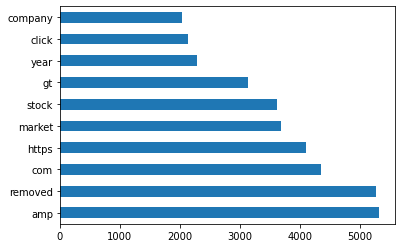

In [221]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names()) # cvec is the CountVectorizer object

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh'); # head(10) gives top ten words

## Baseline Accuracy

In [222]:
y_test.value_counts(normalize=True)

0    0.516236
1    0.483764
Name: subreddit, dtype: float64

# Reinstantiate Train and Test Data

To avoid error of instantiating/fitting count vectorizer down below

In [223]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

# Logistic Regression with Count Vectorizer

In [231]:
pipe = Pipeline([('cvec', CountVectorizer()),
                 ('lr', LogisticRegression(solver='lbfgs'))
                ])

In [232]:
cross_val_score(pipe, X_train, y_train, cv=5)


c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

array([0.80491329, 0.80154143, 0.78746988, 0.78987952, 0.79373494])

In [238]:
# ii. Fit into model
pipe.fit(X_train, y_train)

# Training score
print(pipe.score(X_train, y_train))

# Test score
print(pipe.score(X_test, y_test))

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9649224245928496
0.8014475743348983


### GridSearch

In [240]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.8,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
#scorers dictionary allows us to prioritize which score we want for the model. Then we refit back the parameters to our model
gs_count_logreg = GridSearchCV(pipe,param_grid=pipe_params,scoring=scorers,refit='accuracy_score', cv=5)

In [241]:
gs_count_logreg.fit(X_train, y_train)

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.8, 0.9, 0.95],
                         'cvec__max_features': [2500, 3000, 3500],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             refit='accuracy_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [242]:
print(gs_count_logreg.best_score_)
gs_count_logreg.best_params_

0.782692202335353


{'cvec__max_df': 0.8,
 'cvec__max_features': 3500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [243]:
gs_count_logreg.score(X_train, y_train)


0.9002601908065915

In [244]:
gs_count_logreg.score(X_test, y_test)


0.7832550860719875

### Accuracy Check

#### Pipeline Accuracy

In [269]:
# Get predictions
preds = pipe.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


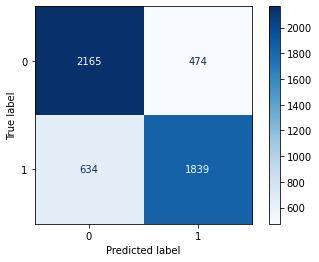

In [270]:
# View confusion matrix

plot_confusion_matrix(gs_count_logreg, X_test, y_test, cmap='Blues', values_format='d');

In [271]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.837059492231906


In [272]:
# Calculate the sensitivity

sens = tp/(tp+fn)

print('Sensitivity:', sens)

Sensitivity: 0.7634452082490901


In [273]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

print('Accuracy:', accuracy)

Accuracy: 0.8014475743348983


---

#### Gridsearch Accuracy

In [261]:
# Get predictions
preds = gs_count_logreg.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


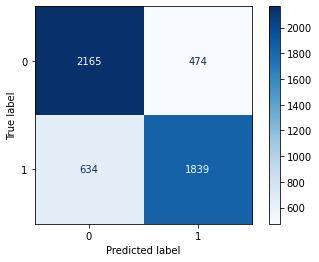

In [265]:
# View confusion matrix

plot_confusion_matrix(gs_count_logreg, X_test, y_test, cmap='Blues', values_format='d');

In [266]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8203865100416825


In [267]:
# Calculate the sensitivity

sens = tp/(tp+fn)

print('Sensitivity:', sens)

Sensitivity: 0.7436312171451678


In [268]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

print('Accuracy:', accuracy)

Accuracy: 0.7832550860719875


# Logistic Regression with TIFD Vectorizer

In [245]:
pipe_tfid_logreg = Pipeline([('tfid', TfidfVectorizer()),
                 ('lr', LogisticRegression(solver='lbfgs'))
                ])

In [246]:
cross_val_score(pipe_tfid_logreg, X_train, y_train, cv=5)


array([0.79768786, 0.79865125, 0.79084337, 0.7946988 , 0.78554217])

In [247]:
# ii. Fit into model
pipe_tfid_logreg.fit(X_train, y_train)

# Training score
print(pipe_tfid_logreg.score(X_train, y_train))

# Test score
print(pipe_tfid_logreg.score(X_test, y_test))

0.8892743567505059
0.7893192488262911


### Gridsearch

In [248]:
pipe2_params = {
    'tfid__max_features': [2500, 3000, 3500],
    'tfid__min_df': [1, 2],
    'tfid__max_df': [.8,.9, .95],
    'tfid__ngram_range': [(1,1), (1,2)]
}


gs_tfid_logreg = GridSearchCV(pipe_tfid_logreg,param_grid=pipe2_params,scoring=scorers,refit='accuracy_score', cv=5)

In [249]:
gs_tfid_logreg.fit(X_train, y_train)
print(gs_tfid_logreg.best_score_)
gs_tfid_logreg.best_params_

0.7711281194140724


{'tfid__max_df': 0.8,
 'tfid__max_features': 3500,
 'tfid__min_df': 1,
 'tfid__ngram_range': (1, 1)}

In [250]:
gs_tfid_logreg.score(X_train, y_train)

0.8428254794256529

In [251]:
gs_tfid_logreg.score(X_test, y_test)

0.7666275430359938

# Naive Bayes with Count Vectorizer

In [233]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [234]:
cross_val_score(pipe3, X_train, y_train, cv=5)

array([0.74566474, 0.7495183 , 0.75325301, 0.76337349, 0.73204819])

In [237]:
# ii. Fit into model
pipe3.fit(X_train, y_train)

# Training score
print(pipe3.score(X_train, y_train))

# Test score
print(pipe3.score(X_test, y_test))

0.8238411872410137
0.7517605633802817


### Gridsearch

In [225]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
# these are for the Grid Search to find the optimum combination of hyperparameters

In [226]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe3, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [227]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [228]:
# What's the best score?
print(gs.best_score_)

0.7219817536040114


In [229]:
# Score model on training set.
gs.score(X_train, y_train)

0.7467476149176062

In [230]:
# Score model on testing set.
gs.score(X_test, y_test)

0.7230046948356808

# Naive Bayes with TIFD Vectorizer

In [252]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [259]:
cross_val_score(pipe_tvec, X_train, y_train, cv=5)

array([0.76734104, 0.77986513, 0.76048193, 0.7739759 , 0.76481928])

In [260]:
# ii. Fit into model
pipe_tvec.fit(X_train, y_train)

# Training score
print(pipe_tvec.score(X_train, y_train))

# Test score
print(pipe_tvec.score(X_test, y_test))

0.8836850727570589
0.7721048513302035


### Gridsearch

In [253]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [254]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.

In [255]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [256]:
print(gs_tvec.best_score_)

0.7530110267660236


In [257]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.8033150236099065

In [258]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.7486306729264476